# Workaround Example for Cleaning Residual 1/f Noise in NIRSpec IFU Products
--------------------------------------------------------------------------------------------------------
**Latest update**: August 22, 2023.

## Notebook Goals
Produce a cleaned rate file to use as input for the level 2 and 3 pipelines.

## Introduction

This workaround is intended to address a known issue with NIRSpec pipeline products: negative and/or surplus flux in the extracted 1-D spectrum is seen, typically with an irregular wavelength-dependent undulation. The cause of this artifact is correlated noise from low-level detector thermal instabilities, seen as vertical banding in 2-D count rate images, particularly in exposures of the NRS2 detector. While the IRS2 readout mode reduces this effect, it is not completely eliminated.

This workaround uses an external package, developed by Bernard Rauscher, called [NSClean](https://webb.nasa.gov/content/forScientists/publications.html#NSClean), which uses dark areas of the detector to fit a background model to the data in Fourier space.  It requires an input mask to identify all dark areas of the detector. The more thorough and complete this mask is, the better the background fit.  In this notebook, we will use some metadata from a previously processed data product to create a mask.  In some cases, this mask may not be complete enough for the best possible noise removal.  If needed, see the NSClean documentation for some suggestions on manually creating a custom mask.

This notebook uses as an example an ERS observation from program 1335: an IFU observation of XID2028 with filter F100LP and grating G140H.

Use this workaround until a residual cleaning algorithm is incorporated into the pipeline.

## Set up

Prior to running this notebook, you will need to install the JWST pipeline and an external package called NSClean, developed by B. Rauscher.

It is recommended to install these packages into a new environment.  For example, using Anaconda:

```
conda create -n nsclean python=3.11
conda activate nsclean
```

Then, the latest pipeline and supporting packages can be installed via pip:

```
pip install jwst matplotlib jupyter pandas
```

If you have not used the pipeline before, you may also need to set some environment variables for retrieving reference data from CRDS, following the pipeline [Quickstart Guide](https://jwst-pipeline.readthedocs.io/en/latest/getting_started/quickstart.html).

Finally, download the latest version of the [NSClean code](https://webb.nasa.gov/content/forScientists/publications.html#NSClean). Unpack the archive and install the contained code.

For the latest version at time of writing (NSClean v1.9), the archive contains a directory called `nsclean_1.9`. The code may be installed with:

```
pip install -e nsclean_1.9
```

After installing all required packages, restart the jupyter server from the nsclean environment and open this notebook.  The following import step should now succeed.

Import necessary packages.

In [1]:
import json
import logging
import os
import requests
import warnings

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip

import nsclean
from jwst.datamodels import dqflags
from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

# hide all log and warning messages
logging.disable(logging.WARNING)
warnings.simplefilter('ignore', RuntimeWarning)

Define a function to download a named file via the MAST API. The function includes authentication logic, but this example uses public data, so no MAST API token is required.

In [2]:
def get_jwst_file(name, mast_api_token=None):
    """Retrieve a JWST data file from MAST archive."""
    mast_url = "https://mast.stsci.edu/api/v0.1/Download/file"
    params = dict(uri=f"mast:JWST/product/{name}")
    if mast_api_token:
        headers = dict(Authorization=f"token {mast_api_token}")
    else:
        headers = {}
    r = requests.get(mast_url, params=params, headers=headers, stream=True)
    r.raise_for_status()
    with open(name, "wb") as fobj:
        for chunk in r.iter_content(chunk_size=1024000):
            fobj.write(chunk)

Create a list of filenames. Download the data from MAST.

In [3]:
obs_ids = ['jw01335004001_03101_00002']
detectors = [1, 2]

# specify rate and calibrated data products
rate_names = []
cal_names = []
for obs_id in obs_ids:
    for detector in detectors:
        rate_names.append(f'{obs_id}_nrs{detector}_rate.fits')
        cal_names.append(f'{obs_id}_nrs{detector}_cal.fits')

# download all the FITS files
for name in rate_names + cal_names:
    print(f'Downloading {name}')
    get_jwst_file(name)

## Create a mask from a calibrated file

The goal in creating the mask is to identify (mark True) any pixel that is unilluminated.  Here, we mark the following detector areas:

- pixels designated as science areas for IFU data
- traces from failed-open MSA shutters
- 5-sigma outliers
- any pixel set to NaN in the rate data.

Create and save a mask identifying dark areas of the detector.

In [4]:
mask_names = []
for rate_file, cal_file in zip(rate_names, cal_names):
    # copy SCI data from rate file
    with fits.open(rate_file) as hdul:
        rate_sci = hdul['SCI'].data.copy()

    # copy DQ data from cal file
    with fits.open(cal_file) as hdul:
        cal_dq = hdul['DQ'].data.copy()

    # initialize mask with everything set to False
    mask = np.full(np.shape(cal_dq), False)

    # find non-science pixels and set them to True
    dark = np.where(cal_dq & dqflags.pixel['NON_SCIENCE'])
    mask[dark] = True

    # find traces of failed open shutters and set them to False
    fail_open = np.where(cal_dq & dqflags.pixel['MSA_FAILED_OPEN'])
    mask[fail_open] = False

    # find NaNs from the rate file
    # set them to 0 in the rate data and False in the mask
    is_nan = np.isnan(rate_sci)
    rate_sci[is_nan] = 0
    mask[is_nan] = False

    # ignore the entire fixed slit area:
    # set it to False in the mask
    mask[922:1116, :] = False

    # keep the left and right reference pixel columns
    mask[:, :5] = True
    mask[:, -5:] = True

    # get stats to flag outliers and ignore them in the mask
    scale = 5
    _, med, sig = sigma_clipped_stats(rate_sci, mask=~mask, mask_value=0, sigma=5.0)
    outliers = np.where(rate_sci > med + scale * sig)
    mask[outliers] = False

    # save the mask to disk
    outname = rate_file.replace('rate', 'mask')
    fits.writeto(outname, mask.astype(np.uint8), overwrite=True)
    print(f"Saved {outname}") 

    mask_names.append(outname)

Saved jw01335004001_03101_00002_nrs1_mask.fits
Saved jw01335004001_03101_00002_nrs2_mask.fits


## Verify the mask keeps only unilluminated data

Check the mask against the rate data to make sure it keeps only dark areas of the detector.

In this example, note that there are still some remaining illuminated areas, primarily due to transient artifacts.

Plot the rate data with masked areas blocked.

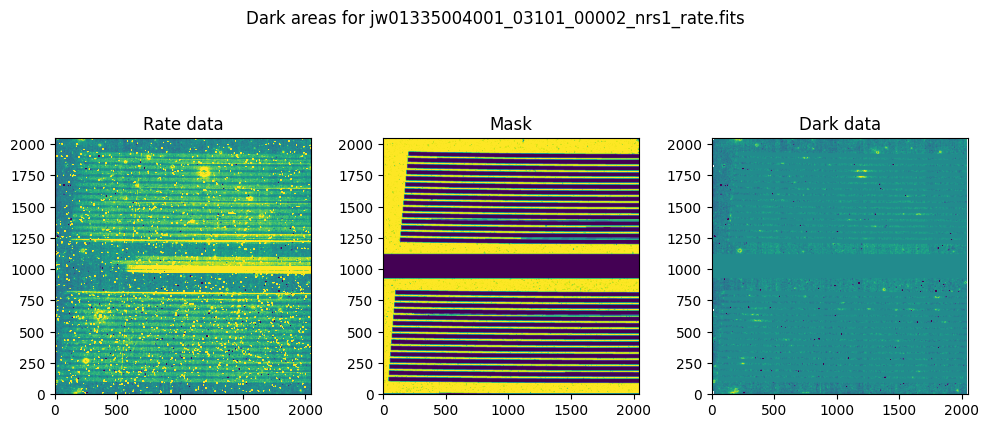

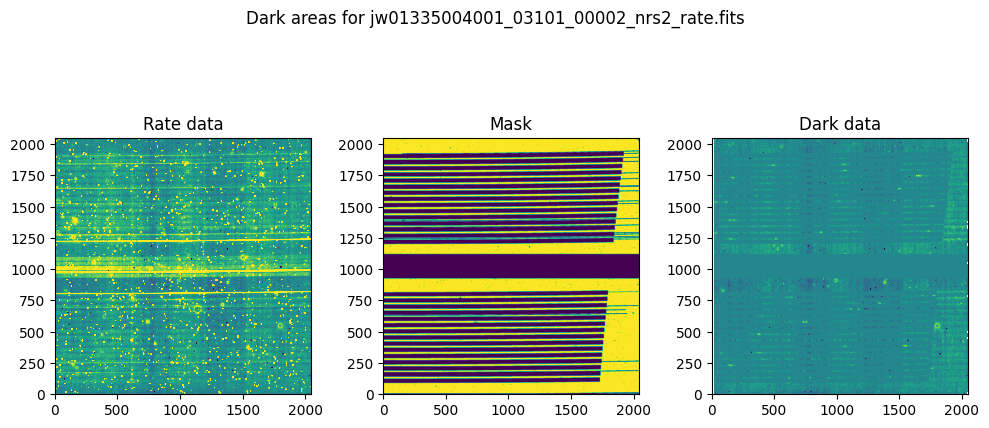

In [5]:
for rate_file, mask_file in zip(rate_names, mask_names):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    plt.suptitle(f'Dark areas for {os.path.basename(rate_file)}')
    
    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data

    with fits.open(rate_file) as hdulist:
        sci = hdulist['SCI'].data

    masked_sci = sci.copy()
    masked_sci[mask == 0] = 0
    vmin = np.nanpercentile(masked_sci, 1)
    vmax = np.nanpercentile(masked_sci, 99)
    
    sci[np.isnan(sci)] = 0
    ax[0].imshow(sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[0].set_title('Rate data')
    
    ax[1].imshow(mask, origin='lower', vmin=0, vmax=1)
    ax[1].set_title('Mask')
    
    ax[2].imshow(masked_sci, origin='lower', vmin=vmin, vmax=vmax)
    ax[2].set_title('Dark data')

    fig.tight_layout()

## Use the mask to clean the rate data

We can use the NSClean package with the created mask to update the rate data, removing residual noise.

In some situations, the cleaning step may fail to find a fit to the background noise.  This may occur if the mask does not contain enough unilluminated data (marked True).  In particular, every column in the mask except for the first and last 4 columns must contain some pixels marked True.

For each file, instantiate the cleaner with the mask, then call the clean function.

In [6]:
cleaned_rate_names = []
for rate_file, mask_file in zip(rate_names, mask_names):

    with fits.open(mask_file) as hdulist:
        mask = hdulist[0].data.astype(bool)

    rate_hdulist = fits.open(rate_file)
    sci = rate_hdulist['SCI'].data
    detector = rate_hdulist[0].header['DETECTOR']

    # set NaN values to zero
    is_nan = np.isnan(sci)
    sci[is_nan] = 0

    # instantiate the cleaner
    cleaner = nsclean.NSClean(detector, mask)

    # clean the data
    try:
        cleaned_sci = cleaner.clean(sci, buff=False)
    except np.linalg.LinAlgError:
        print(f'Cannot clean {os.path.basename(rate_file)}')
        cleaned_rate_names.append(None)
        continue
    
    # restore NaNs
    cleaned_sci[is_nan] = np.nan  # restore NANs

    # save result
    rate_hdulist['SCI'].data = cleaned_sci

    outname = rate_file.replace('rate', 'rate_cleaned')
    rate_hdulist.writeto(outname, overwrite=True)
    rate_hdulist.close()
    print(f'Saved {os.path.basename(outname)}')

    cleaned_rate_names.append(outname)

Saved jw01335004001_03101_00002_nrs1_rate_cleaned.fits
Saved jw01335004001_03101_00002_nrs2_rate_cleaned.fits


## Check the cleaned data

We can now compare the cleaned data to the original rate file and verify that the noise has been removed.

In many cases, the cleaning process introduces new artifacts to the rate file.  These should be carefully examined and weighed against the benefits of the noise reduction.  If transient artifacts like snowballs are interfering with the cleaning process, it may be beneficial to manually edit the mask to remove these areas from consideration in the background fit. 

Plot the original and cleaned data, as well as a residual map.

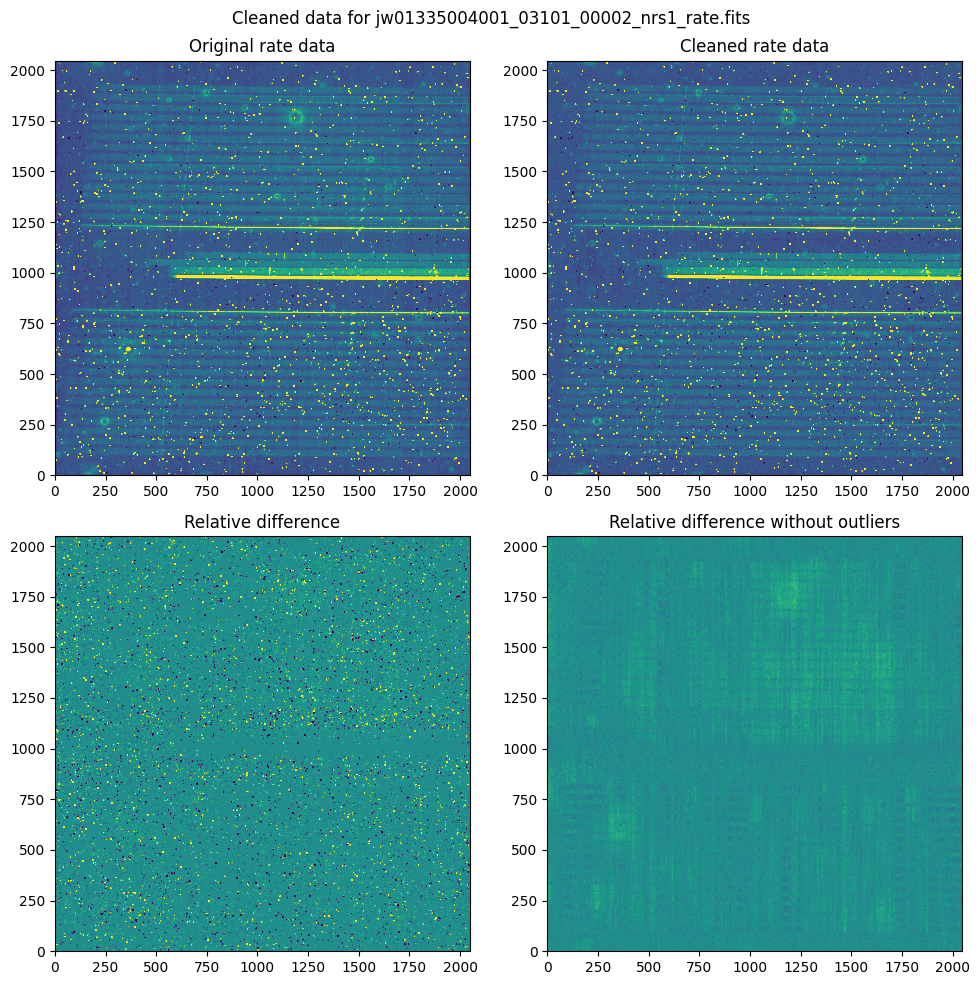

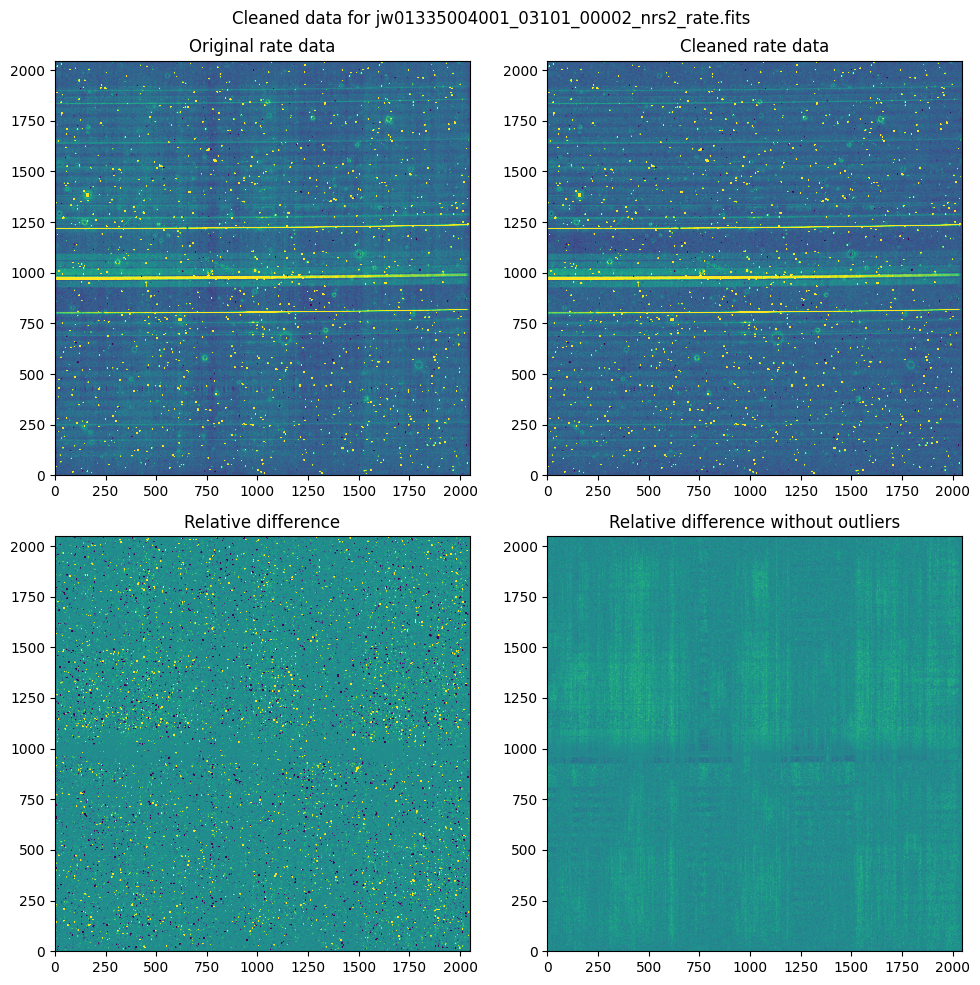

In [7]:
for rate_file, cleaned_file in zip(rate_names, cleaned_rate_names):
    if cleaned_file is None:
        continue
        
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    plt.suptitle(f'Cleaned data for {os.path.basename(rate_file)}')

    with fits.open(rate_file) as hdulist:
        original = hdulist['SCI'].data

    with fits.open(cleaned_file) as hdulist:
        cleaned = hdulist['SCI'].data

    vmin = np.nanpercentile(original, 1)
    vmax = np.nanpercentile(original, 99)
    
    original[np.isnan(original)] = 0
    cleaned[np.isnan(cleaned)] = 0
    ax[0, 0].imshow(original, origin='lower', vmin=vmin, vmax=vmax)
    ax[0, 0].set_title('Original rate data')
    
    ax[0, 1].imshow(cleaned, origin='lower', vmin=vmin, vmax=vmax)
    ax[0, 1].set_title('Cleaned rate data')

    diff = (original - cleaned) / original
    diff[~np.isfinite(diff)] = 0
    vmin = np.nanpercentile(diff, 1)
    vmax = np.nanpercentile(diff, 99)
    ax[1, 0].imshow(diff, origin='lower', vmin=vmin, vmax=vmax)
    ax[1, 0].set_title('Relative difference')

    hide_outliers = np.ma.filled(sigma_clip(diff, masked=True), fill_value=0)
    vmin = np.nanpercentile(hide_outliers, 1)
    vmax = np.nanpercentile(hide_outliers, 99)
    ax[1, 1].imshow(hide_outliers, origin='lower', vmin=vmin, vmax=vmax)
    ax[1, 1].set_title('Relative difference without outliers')

    fig.tight_layout()

## Compare extracted spectra

We can now extract a spectrum from the cleaned data and compare it to the spectrum extracted from the original rate file.

Run the spec2 pipeline on both sets of rate data. This will take some time to complete.

In [8]:
x1d_names = []
cleaned_x1d_names = []
for rate_file, cleaned_file in zip(rate_names, cleaned_rate_names):
    if cleaned_file is None:
        continue

    # original rate data
    print(f'Processing {os.path.basename(rate_file)}...')
    pipe = Spec2Pipeline()
    pipe.save_results = True
    pipe(rate_file)
    x1d = rate_file.replace('rate', 'x1d')
    x1d_names.append(x1d)
    print(f'Saved {os.path.basename(x1d)}\n')

    # cleaned rate data
    print(f'Processing {os.path.basename(cleaned_file)}...')
    pipe = Spec2Pipeline()
    pipe.save_results = True
    pipe(cleaned_file)
    x1d = cleaned_file.replace('rate_cleaned', 'rate_cleaned_x1d')
    cleaned_x1d_names.append(x1d)
    print(f'Saved {os.path.basename(x1d)}\n')

Processing jw01335004001_03101_00002_nrs1_rate.fits...
Saved jw01335004001_03101_00002_nrs1_x1d.fits

Processing jw01335004001_03101_00002_nrs1_rate_cleaned.fits...
Saved jw01335004001_03101_00002_nrs1_rate_cleaned_x1d.fits

Processing jw01335004001_03101_00002_nrs2_rate.fits...
Saved jw01335004001_03101_00002_nrs2_x1d.fits

Processing jw01335004001_03101_00002_nrs2_rate_cleaned.fits...
Saved jw01335004001_03101_00002_nrs2_rate_cleaned_x1d.fits



Plot both spectra within a wavelength range of interest.

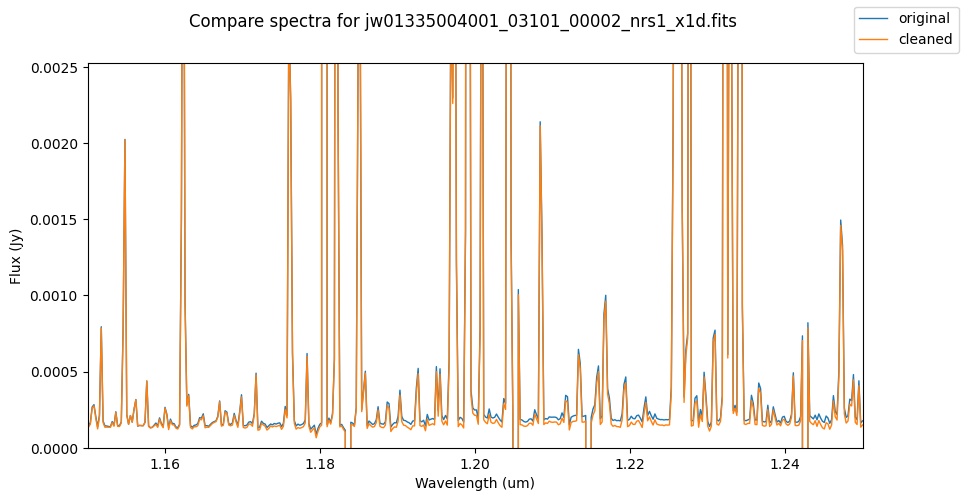

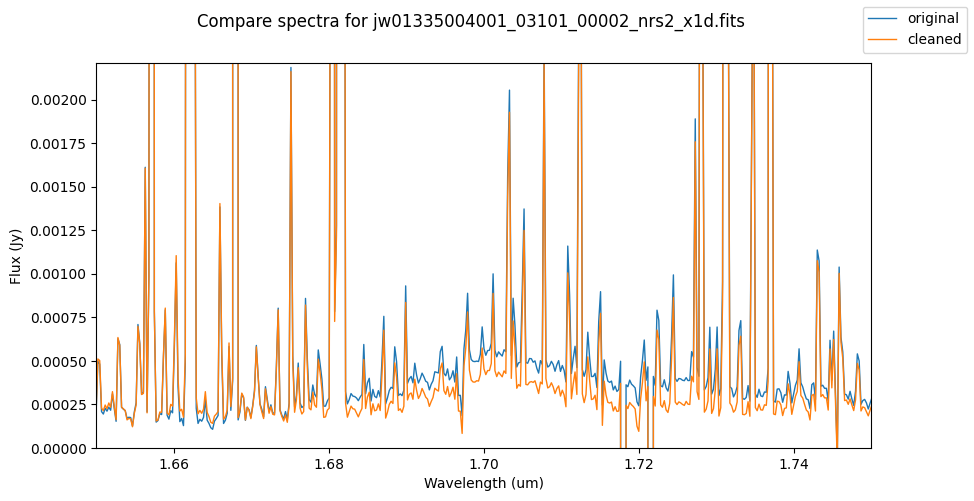

In [9]:
scale_percent = 3
wavelength_range = {'nrs1': [1.15, 1.25],
                    'nrs2': [1.65, 1.75]}

for original, cleaned in zip(x1d_names, cleaned_x1d_names):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.suptitle(f'Compare spectra for {os.path.basename(original)}')
    all_flux = np.array([])


    # original spectrum
    with fits.open(original) as hdulist:
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                data = hdu.data
                header = hdu.header
                ax.plot(data['WAVELENGTH'], data['FLUX'], linewidth=1, label='original')
                    
                ax.set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax.set_ylabel(f"Flux ({header['TUNIT2']})")
                all_flux = np.hstack([all_flux, data['FLUX']])
    
    # new extracted spectrum
    with fits.open(cleaned) as hdulist:
        for extnum in range(len(hdulist)):
            hdu = hdulist[extnum]
            if hdu.name == 'EXTRACT1D':
                data = hdu.data
                header = hdu.header
                ax.plot(data['WAVELENGTH'], data['FLUX'], linewidth=1, label='cleaned')
                    
                ax.set_xlabel(f"Wavelength ({header['TUNIT1']})")
                ax.set_ylabel(f"Flux ({header['TUNIT2']})")
                all_flux = np.hstack([all_flux, data['FLUX']])

    for key in wavelength_range:
        if key in original:
            if wavelength_range[key] is not None:
                ax.set_xlim(wavelength_range[key])    
    ax.set_ylim([np.nanpercentile(all_flux, scale_percent), 
                 np.nanpercentile(all_flux, 100 - scale_percent)])

    handles, labels = ax.get_legend_handles_labels()
    if len(labels) < 20:
        fig.legend()


Note that in the portion of the spectrum near 1.2 um for NRS1 and 1.7um for NRS2, the excess flux due to 1/f noise is reduced.